## Closed Loop Simulation Notebook

This notebook breaks down the closed loop simulation in different jupyter notebook cells. The aim of this notebook is to ease the debugging and development of the different packages involved in the Optical Feedback Control loop.

This notebook was last run on Aug. 12th 2021. 
Details:
- Machine size: 32 CPUs, 16 cores per socket (2 sockets).
- Stack release: 2021_25, Last verified to run 2021-08-12
- ts_phosim release: v1.4.0


### Required python packages

In [1]:
import argparse
import logging
import numpy as np
import os
import shutil
import subprocess
import sys
import time

from lsst.ts.phosim.CloseLoopTask import CloseLoopTask
from lsst.ts.phosim.telescope.TeleFacade import TeleFacade
from lsst.ts.phosim.PlotUtil import plotFwhmOfIters
from lsst.daf import butler as dafButler
from lsst.ts.wep.Utility import CamType, FilterType, runProgram
from lsst.ts.wep.ctrlIntf.SensorWavefrontData import SensorWavefrontData
from lsst.ts.phosim.Utility import getPhoSimPath, getAoclcOutputPath, getCamera

In [2]:
from tqdm import tqdm

### Default arguments and initializations

Initialize default arguments to run the closed loop and initialize the ClosedLoopTask

In [3]:
%%time

# Set the parser
parser = argparse.ArgumentParser(
    description="Run AOS closed-loop simulation (default is amplifier files)."
)
parser = CloseLoopTask.setDefaultParser(parser)
parser = CloseLoopTask.setImgParser(parser)

# Get the default arguments
sys.argv = ['-f']
args = parser.parse_args()

# Print default arguments
print(args)

logger = logging.getLogger()
logger.setLevel(args.log_level)

# Initialize the ClosedLoopTask
closeLoopTask = CloseLoopTask()

Namespace(boresightDeg=[0, 0], clobber=False, eimage=False, filterType='', inst='comcam', iterNum=5, log_level=20, m1m3FErr=0.05, numOfProc=1, output='', rotCam=0.0, skyFile='')
CPU times: user 4.53 ms, sys: 765 µs, total: 5.3 ms
Wall time: 4.21 ms


### Set paths and arguments

Customize the following arguments to run the simulation you are interested in. If not stated in the following code cell, the arguments are taken to be the default ones. Note that this paths should be changed if another user is running them and wants to change the directory addresses.

In [4]:
PHOSIMPATH = "/project/gmegias/aos/lsst_stack/phosim_syseng4/"
AOCLCOUTPUTPATH = "/project/gmegias/aos/lsst_stack/ts_phosim/output/"
os.environ["PHOSIMPATH"] = PHOSIMPATH
os.environ["AOCLCOUTPUTPATH"] = AOCLCOUTPUTPATH

In [5]:
args.inst = 'comcam' 
args.numOfProc = 32 
args.boresightDeg = [0.03, -0.02]
args.skyFile = '/project/gmegias/aos/lsst_stack/ts_phosim/tests/testData/sky/skyComCam.txt'
args.output = '/project/gmegias/aos/lsst_stack/perturbations/test/'

if os.path.exists(args.output):
    shutil.rmtree(args.output)

### Intializations and initial configurations

First, initialize the variables from the arguments dictionary.

In [6]:
boresight = args.boresightDeg
rotCamInDeg = args.rotCam
useEimg = args.eimage
m1m3ForceError = args.m1m3FErr
numPro = args.numOfProc
iterNum = args.iterNum
doErsDirCont = args.clobber
pathSkyFile = args.skyFile

Check and set the required configurations to run the simulation loop.

In [7]:
%%time

# Check the input arguments
camType, instName = closeLoopTask.getCamTypeAndInstName(args.inst)
filterType = closeLoopTask.getFilterType(args.filterType)
baseOutputDir = closeLoopTask.checkAndCreateBaseOutputDir(args.output)

if doErsDirCont:
    closeLoopTask.eraseDirectoryContent(baseOutputDir)

closeLoopTask.checkBoresight(boresight, args.skyFile)

closeLoopTask.assignImgType(useEimg)

# Configure the components
closeLoopTask.configSkySim(instName, pathSkyFile = args.skyFile, starMag=15)

pathIsrDir = closeLoopTask.createIsrDir(baseOutputDir)
closeLoopTask.configWepCalc(
    camType, pathIsrDir, filterType, boresight, rotCamInDeg, useEimg=useEimg
)

closeLoopTask.configOfcCalc(instName)
closeLoopTask.configPhosimCmpt(
    filterType, rotCamInDeg, m1m3ForceError, numPro
)

# Set the defocal distance for WEP calculator based on the setting
# file in the telescope
closeLoopTask.setWepCalcWithDefocalDist()

/project/gmegias/aos/lsst_stack/ts_wep/python/lsst/ts/wep/bsc/WcsSol.py:45: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  self._camera = obs_lsst.lsstCamMapper.LsstCamMapper().camera


CameraMapper INFO: Loading Posix exposure registry from .
CameraMapper INFO: Loading Posix exposure registry from .
CPU times: user 3min, sys: 1.85 s, total: 3min 2s
Wall time: 3min 3s


### Generate butler gen3 repository.

In [8]:
%%time

# generate bluter gen3 repo if needed
butlerRootPath = os.path.join(baseOutputDir, "phosimData")
if closeLoopTask.useCcdImg():
    closeLoopTask.generateButler(butlerRootPath, instName)
    closeLoopTask.generateRefCatalog(
        instName = instName,
        butlerRootPath = butlerRootPath,
        pathSkyFile = pathSkyFile,
    )
    
closeLoopTask.phosimCmpt.tele.setInstName(camType)

LsstCamMapper WARN: Unable to find valid calib root directory
CameraMapper INFO: Loading Posix exposure registry from /project/gmegias/aos/lsst_stack/perturbations/test/phosimData/skydata
root INFO: Running: /software/lsstsw/stack_20210813/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/pipe_tasks/21.0.0-135-g7593ff3c+f47b53ceaf/bin/ingestReferenceCatalog.py /project/gmegias/aos/lsst_stack/perturbations/test/phosimData/skydata /project/gmegias/aos/lsst_stack/perturbations/test/phosimData/skydata/sky_data.csv --configfile /project/gmegias/aos/lsst_stack/perturbations/test/phosimData/skydata/cat.cfg
IngestIndexedReferenceTask INFO: Creating 131072 file locks.


/software/lsstsw/stack_20210813/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/pipe_base/22.0.1-21-g507161b+fa50ca1d3b/python/lsst/pipe/base/argumentParser.py:693: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(outputs=outputs)
/software/lsstsw/stack_20210813/stack/miniconda3-py38_4.9.2-0.7.0/Linux64/pipe_base/22.0.1-21-g507161b+fa50ca1d3b/python/lsst/pipe/base/argumentParser.py:693: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(outputs=outputs)


IngestIndexedReferenceTask INFO: File locks created.
IngestIndexedReferenceTask INFO: Completed 1 / 1 files: 100 % complete 
root WARN: Unable to retrieve exit status ('NoneType' object is not iterable); assuming success


py.warnings WARNING: /software/lsstsw/stack_20210813/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe/lib/python3.8/site-packages/click/core.py:610: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  return callback(*args, **kwargs)

py.warnings WARNING: /software/lsstsw/stack_20210813/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe/lib/python3.8/site-packages/click/core.py:610: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  return callback(*args, **kwargs)

LsstCamMapper WARNING: Unable to find valid calib root directory
LsstCamMapper WARNING: Unable to find valid calib root directory
convertRepo INFO: Preparing ref_cat cal_ref_cat from root /project/gmegias/aos/lsst_stack/perturbations/test/phosimData/skydata.
convertRepo INFO: Looking for skymaps in root /project/gmegias/aos/lsst_stack/perturbations/test/phosi

CPU times: user 50.9 ms, sys: 96.3 ms, total: 147 ms
Wall time: 3min 14s


### Simulation loop initialization

Initialize the state of the telescope to run the simulation. This cell also sets common file and directory names required for the closed loop simulation.

In [9]:
%%time

# Set the telescope state to be the same as the OFC
state0 = closeLoopTask.ofcCalc.ofc_controller.aggregated_state
closeLoopTask.phosimCmpt.setDofInUm(state0)

# Get the list of referenced sensor name (field positions)
refSensorNameList = closeLoopTask.getSensorNameListOfFields(instName)
refSensorIdList = closeLoopTask.getSensorIdListOfFields(instName)

# Common file and directory names
opdZkFileName = "opd.zer"
opdPssnFileName = "PSSN.txt"
outputDirName = "pert"
outputImgDirName = "img"
iterDefaultDirName = "iter"
dofInUmFileName = "dofPertInNextIter.mat"
fwhmItersFileName = "fwhmIters.png"

# Specific file names to the amplifier/eimage
wfsZkFileName = "wfs.zer"

CPU times: user 87.8 ms, sys: 5.91 ms, total: 93.7 ms
Wall time: 91.5 ms


In [10]:
iterCount = 1
obsId = 9006000
# Set the observation Id
closeLoopTask.phosimCmpt.setSurveyParam(obsId=obsId)

# The iteration directory
iterDirName = "%s%d" % (iterDefaultDirName, iterCount)

# Set the output directory
outputDir = os.path.join(baseOutputDir, iterDirName, outputDirName)
closeLoopTask.phosimCmpt.setOutputDir(outputDir)

# Set the output image directory
outputImgDir = os.path.join(baseOutputDir, iterDirName, outputImgDirName)
closeLoopTask.phosimCmpt.setOutputImgDir(outputImgDir)

In [11]:
# Generate the OPD image
print("Preparing PhoSim....")
t0 = time.time()
argString = closeLoopTask.phosimCmptgetOpdArgsAndFilesForPhoSim(instName)
ttl_time = time.time() - t0
print("PhoSim prepared, took {} seconds.".format(ttl_time))

Preparing PhoSim....
PhoSim prepared, took 126.44054913520813 seconds.


In [12]:
print("Running PhoSim....")
t0 = time.time()
closeLoopTask.phosimCmpt.runPhoSim(argString)
ttl_time = time.time() - t0
print("PhoSim run, took {} seconds.".format(ttl_time))

Running PhoSim....
PhoSim run, took 84.94303894042969 seconds.


In [13]:
# Analyze the OPD data
# Rotate OPD in the reversed direction of camera
print("Analyzing OPD data....")
t0 = time.time()
closeLoopTask.phosimCmpt.analyzeOpdData(
    instName,
    zkFileName=opdZkFileName,
    rotOpdInDeg=-rotCamInDeg,
    pssnFileName=opdPssnFileName,
)
ttl_time = time.time() - t0
print("OPD data analyzed, took {} seconds.".format(ttl_time))

Analyzing OPD data....
OPD data analyzed, took 4.408241510391235 seconds.


In [14]:
# Get the PSSN from file
pssn = closeLoopTask.phosimCmpt.getOpdPssnFromFile(opdPssnFileName)
print("Calculated PSSN is %s." % pssn)

# Get the GQ effective FWHM from file
gqEffFwhm = closeLoopTask.phosimCmpt.getOpdGqEffFwhmFromFile(opdPssnFileName)
print("GQ effective FWHM is %.4f." % gqEffFwhm)

# Set the FWHM data
print("Setting FWHM data...")
t0 = time.time()
fwhm, sensor_id = closeLoopTask.phosimCmpt.getListOfFwhmSensorData(
    opdPssnFileName, refSensorIdList
)

closeLoopTask.ofcCalc.set_fwhm_data(fwhm, sensor_id)
ttl_time = time.time() - t0
print("FWHM data set, took {} seconds.".format(ttl_time))

Calculated PSSN is [0.6305613  0.61835184 0.59475278 0.62761457 0.61402869 0.59458356
 0.6226892  0.61750365 0.6018036 ].
GQ effective FWHM is 0.5172.
Setting FWHM data...
FWHM data set, took 0.0020673274993896484 seconds.


### Define Wavefront Estimation functions

This re-definitiion is required to ensure WEP files are created in the correct directory.

In [15]:
%%time

#extraObsId = obsId + 1
#intraObsId = obsId + 2 
listOfWfErr = closeLoopTask._calcWfErrFromImg(
                    obsId, butlerRootPath=butlerRootPath, instName=instName, snap=0
                )
#listOfWfErr = _calcWfErrFromImg(closeLoopTask, obsId, butlerRootPath, instName)
#listOfWfErr = closeLoopTask.phosimCmpt.mapOpdDataToListOfWfErr(
#    opdZkFileName, refSensorIdList
#)

Repackaging sensor R22_S00
Saved as /project/gmegias/aos/lsst_stack/perturbations/test/iter1/img/tmp/CC_H_20211231_006002_R22_S00.fits
Repackaging sensor R22_S01
Saved as /project/gmegias/aos/lsst_stack/perturbations/test/iter1/img/tmp/CC_H_20211231_006002_R22_S01.fits
Repackaging sensor R22_S02
Saved as /project/gmegias/aos/lsst_stack/perturbations/test/iter1/img/tmp/CC_H_20211231_006002_R22_S02.fits
Repackaging sensor R22_S10
Saved as /project/gmegias/aos/lsst_stack/perturbations/test/iter1/img/tmp/CC_H_20211231_006002_R22_S10.fits
Repackaging sensor R22_S11
Saved as /project/gmegias/aos/lsst_stack/perturbations/test/iter1/img/tmp/CC_H_20211231_006002_R22_S11.fits
Repackaging sensor R22_S12
Saved as /project/gmegias/aos/lsst_stack/perturbations/test/iter1/img/tmp/CC_H_20211231_006002_R22_S12.fits
Repackaging sensor R22_S20
Saved as /project/gmegias/aos/lsst_stack/perturbations/test/iter1/img/tmp/CC_H_20211231_006002_R22_S20.fits
Repackaging sensor R22_S21
Saved as /project/gmegias/ao

ingest INFO: Successfully extracted metadata from 9 files with 0 failures
ingest INFO: Exposure LSSTComCam:CC_H_20211231_006002 ingested successfully
ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
ingest INFO: Ingested 9 distinct Butler datasets
ingest INFO: Successfully extracted metadata from 9 files with 0 failures
ingest INFO: Exposure LSSTComCam:CC_H_20211231_006001 ingested successfully
ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
ingest INFO: Ingested 9 distinct Butler datasets
defineVisits INFO: Defaulting to searching for raw exposures in collection LSSTComCam/raw/all
defineVisits INFO: Preprocessing data IDs.
defineVisits INFO: Registering visit_system 1: by-group-metadata.
defineVisits INFO: Grouping 2 exposure(s) into visits.
defineVisits INFO: Computing regions and other metadata for 2 visit(s).
ctrl.m

isr INFO: Converting exposure to floating point values.
isr INFO: Assembling CCD from amplifiers.
isr INFO: Widening saturation trails.
isr INFO: Applying gain correction instead of flat.
ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'isr' on quantum {instrument: 'LSSTComCam', detector: 4, exposure: 4021123106002, ...} took 4.985 seconds
ctrl.mpexec.mpGraphExecutor INFO: Executed 12 quanta successfully, 0 failed and 16 remain out of total 28 quanta.
 INFO: Loading reference objects from region bounded by [0.11611092, 0.35343999], [-0.35143934, -0.11810867] RA Dec
 INFO: Loaded 1 reference objects
 INFO: Loading reference objects from region bounded by [359.88138903, 0.11872208], [-0.35144007, -0.11811066] RA Dec
 INFO: Loaded 1 reference objects
 INFO: Loading reference objects from region bounded by [359.64667112, 359.88400019], [-0.35143935, -0.11810867] RA Dec
 INFO: Loaded 1 reference objects
 INFO: Loading reference objects from region bounded by [0.11611092, 0.3534399

CPU times: user 781 ms, sys: 350 ms, total: 1.13 s
Wall time: 8min 47s


### Record the wavefront error and save

In [16]:
# Record the wavefront error with the same order as OPD for the
# comparison
print('Recording wavefront error...')
t0 = time.time()
if closeLoopTask.useCcdImg():
    closeLoopTask.phosimCmpt.reorderAndSaveWfErrFile(
        listOfWfErr,
        refSensorNameList,
        getCamera(instName),
        zkFileName=wfsZkFileName,
    )
ttl_time = time.time() - t0
print('Wavefront error recorded. Took {} seconds.'.format(ttl_time))

# Calculate the DOF
print('Calculating DOF...')
t0 = time.time()
wfe = np.array(
    [sensor_wfe.getAnnularZernikePoly() for sensor_wfe in listOfWfErr]
)
sensor_ids = np.array(
    [sensor_wfe.getSensorId() for sensor_wfe in listOfWfErr]
)
ttl_time = time.time() - t0
print('DOF computed. Took {} seconds.'.format(ttl_time))

print('Calculating corrections...')
t0 = time.time()
closeLoopTask.ofcCalc.calculate_corrections(
    wfe=wfe,
    field_idx=sensor_ids,
    filter_name=str('R'),
    gain=-1,
    rot=rotCamInDeg,
)
ttl_time = time.time() - t0
print('Corrections computed. Took {} seconds.'.format(ttl_time))

# Set the new aggregated DOF to phosimCmpt
print('Setting and saving new DOF...')
t0 = time.time()
dofInUm = closeLoopTask.ofcCalc.ofc_controller.aggregated_state
closeLoopTask.phosimCmpt.setDofInUm(dofInUm)

# Save the DOF file
closeLoopTask.phosimCmpt.saveDofInUmFileForNextIter(
    dofInUm, dofInUmFileName=dofInUmFileName
)
ttl_time = time.time() - t0
print('New DOF saved. Took {} seconds.'.format(ttl_time))

# Add the observation ID by 10 for the next iteration
obsId += 10

Recording wavefront error...
Wavefront error recorded. Took 0.007950305938720703 seconds.
Calculating DOF...
DOF computed. Took 0.0004131793975830078 seconds.
Calculating corrections...
Corrections computed. Took 0.1655409336090088 seconds.
Setting and saving new DOF...
New DOF saved. Took 0.0013685226440429688 seconds.


The wavefront error of the first simulation iteration is printed below

In [19]:
print(wfe)

[[-0.07105599 -0.03728988  0.37645333  0.0392639   0.02995426  0.04551182
   0.01198682  0.00934649 -0.00504794  0.00705704 -0.03145979 -0.00290473
  -0.00662934 -0.03047965 -0.00306473  0.01636482  0.00602967 -0.05231028
   0.01354332]
 [-0.06230934 -0.2065775   0.17485962 -0.06873055 -0.06191447 -0.03457004
   0.03365075  0.00360472 -0.01452705  0.03408544  0.00394021  0.01627989
   0.01957985  0.01047506  0.00192995  0.0235407  -0.01778855 -0.0482896
   0.01289665]
 [-0.0462198   0.02189774  0.10332987  0.03663608  0.03398097 -0.06631284
   0.04531734  0.01103811 -0.01799035  0.00159723  0.02202471  0.00948923
   0.00571454 -0.01524594 -0.00707417  0.03208727  0.00819737 -0.05304637
   0.01122915]
 [-0.07797821 -0.00307038  0.29817786  0.09682685  0.01593729 -0.01681193
   0.05598997  0.02019995  0.0066778  -0.01072547  0.00344295 -0.00214571
  -0.0044591  -0.03545741 -0.01047244  0.0302643  -0.02453261 -0.05857955
   0.01280486]
 [-0.06512966  0.24227659  0.13571211 -0.03676353  0.

In [17]:
iterCount = 2

# Set the observation Id
closeLoopTask.phosimCmpt.setSurveyParam(obsId=obsId)

# The iteration directory
iterDirName = "%s%d" % (iterDefaultDirName, iterCount)

# Set the output directory
outputDir = os.path.join(baseOutputDir, iterDirName, outputDirName)
closeLoopTask.phosimCmpt.setOutputDir(outputDir)

# Set the output image directory
outputImgDir = os.path.join(baseOutputDir, iterDirName, outputImgDirName)
closeLoopTask.phosimCmpt.setOutputImgDir(outputImgDir)

# Generate the OPD image
print("Preparing PhoSim....")
t0 = time.time()
argString = closeLoopTask.phosimCmpt.getOpdArgsAndFilesForPhoSim(instName)
ttl_time = time.time() - t0
print("PhoSim prepared, took {} seconds.".format(ttl_time))

print("Running PhoSim....")
t0 = time.time()
closeLoopTask.phosimCmpt.runPhoSim(argString)
ttl_time = time.time() - t0
print("PhoSim run, took {} seconds.".format(ttl_time))

# Analyze the OPD data
# Rotate OPD in the reversed direction of camera
print("Analyzing OPD data....")
t0 = time.time()
closeLoopTask.phosimCmpt.analyzeOpdData(
    instName,
    zkFileName=opdZkFileName,
    rotOpdInDeg=-rotCamInDeg,
    pssnFileName=opdPssnFileName,
)
ttl_time = time.time() - t0
print("OPD data analyzed, took {} seconds.".format(ttl_time))

# Get the PSSN from file
pssn = closeLoopTask.phosimCmpt.getOpdPssnFromFile(opdPssnFileName)
print("Calculated PSSN is %s." % pssn)

# Get the GQ effective FWHM from file
gqEffFwhm = closeLoopTask.phosimCmpt.getOpdGqEffFwhmFromFile(opdPssnFileName)
print("GQ effective FWHM is %.4f." % gqEffFwhm)

# Set the FWHM data
print("Setting FWHM data...")
t0 = time.time()
fwhm, sensor_id = closeLoopTask.phosimCmpt.getListOfFwhmSensorData(
    opdPssnFileName, refSensorIdList
)

closeLoopTask.ofcCalc.set_fwhm_data(fwhm, sensor_id)
ttl_time = time.time() - t0
print("FWHM data set, took {} seconds.".format(ttl_time))

listOfWfErr = closeLoopTask._calcWfErrFromImg(
                    obsId, butlerRootPath=butlerRootPath, instName=instName, snap=0
                )
#listOfWfErr = _calcWfErrFromImg(closeLoopTask, obsId, butlerRootPath, instName)

# Record the wavefront error with the same order as OPD for the
# comparison
print('Recording wavefront error...')
t0 = time.time()
if closeLoopTask.useCcdImg():
    closeLoopTask.phosimCmpt.reorderAndSaveWfErrFile(
        listOfWfErr,
        refSensorNameList,
        getCamera(instName),
        zkFileName=wfsZkFileName,
    )
ttl_time = time.time() - t0
print('Wavefront error recorded. Took {} seconds.'.format(ttl_time))

# Calculate the DOF
print('Calculating DOF...')
t0 = time.time()
wfe = np.array(
    [sensor_wfe.getAnnularZernikePoly() for sensor_wfe in listOfWfErr]
)
sensor_ids = np.array(
    [sensor_wfe.getSensorId() for sensor_wfe in listOfWfErr]
)
ttl_time = time.time() - t0
print('DOF computed. Took {} seconds.'.format(ttl_time))

print('Calculating corrections...')
t0 = time.time()
closeLoopTask.ofcCalc.calculate_corrections(
    wfe=wfe,
    field_idx=sensor_ids,
    filter_name=str('R'),
    gain=-1,
    rot=rotCamInDeg,
)
ttl_time = time.time() - t0
print('Corrections computed. Took {} seconds.'.format(ttl_time))

# Set the new aggregated DOF to phosimCmpt
print('Setting and saving new DOF...')
t0 = time.time()
dofInUm = closeLoopTask.ofcCalc.ofc_controller.aggregated_state
closeLoopTask.phosimCmpt.setDofInUm(dofInUm)

# Save the DOF file
closeLoopTask.phosimCmpt.saveDofInUmFileForNextIter(
    dofInUm, dofInUmFileName=dofInUmFileName
)
ttl_time = time.time() - t0
print('New DOF saved. Took {} seconds.'.format(ttl_time))

# Add the observation ID by 10 for the next iteration
obsId += 10

Preparing PhoSim....
PhoSim prepared, took 117.45119619369507 seconds.
Running PhoSim....
PhoSim run, took 140.3564739227295 seconds.
Analyzing OPD data....
OPD data analyzed, took 4.5739054679870605 seconds.
Calculated PSSN is [0.95613372 0.95814916 0.95569009 0.96089163 0.96134497 0.95896322
 0.95755172 0.95524242 0.95495869].
GQ effective FWHM is 0.1370.
Setting FWHM data...
FWHM data set, took 0.0012350082397460938 seconds.
Repackaging sensor R22_S00
Saved as /project/gmegias/aos/lsst_stack/perturbations/test/iter2/img/tmp/CC_H_20211231_006012_R22_S00.fits
Repackaging sensor R22_S01
Saved as /project/gmegias/aos/lsst_stack/perturbations/test/iter2/img/tmp/CC_H_20211231_006012_R22_S01.fits
Repackaging sensor R22_S02
Saved as /project/gmegias/aos/lsst_stack/perturbations/test/iter2/img/tmp/CC_H_20211231_006012_R22_S02.fits
Repackaging sensor R22_S10
Saved as /project/gmegias/aos/lsst_stack/perturbations/test/iter2/img/tmp/CC_H_20211231_006012_R22_S10.fits
Repackaging sensor R22_S11
S

ingest INFO: Successfully extracted metadata from 9 files with 0 failures
ingest INFO: Exposure LSSTComCam:CC_H_20211231_006012 ingested successfully
ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
ingest INFO: Ingested 9 distinct Butler datasets
ingest INFO: Successfully extracted metadata from 9 files with 0 failures
ingest INFO: Exposure LSSTComCam:CC_H_20211231_006011 ingested successfully
ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
ingest INFO: Ingested 9 distinct Butler datasets
defineVisits INFO: Defaulting to searching for raw exposures in collection LSSTComCam/raw/all
defineVisits INFO: Preprocessing data IDs.
defineVisits INFO: Registering visit_system 1: by-group-metadata.
defineVisits INFO: Grouping 4 exposure(s) into visits.
defineVisits INFO: Computing regions and other metadata for 4 visit(s).
ctrl.m

ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'isr' on quantum {instrument: 'LSSTComCam', detector: 6, exposure: 4021123106011, ...} took 3.923 seconds
ctrl.mpexec.mpGraphExecutor INFO: Executed 11 quanta successfully, 0 failed and 17 remain out of total 28 quanta.
ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'estimateZernikesFamTask' on quantum {instrument: 'LSSTComCam', detector: 0} took 25.517 seconds
ctrl.mpexec.mpGraphExecutor INFO: Executed 12 quanta successfully, 0 failed and 16 remain out of total 28 quanta.
isr INFO: Converting exposure to floating point values.
isr INFO: Assembling CCD from amplifiers.
isr INFO: Widening saturation trails.
isr INFO: Applying gain correction instead of flat.
isr INFO: Converting exposure to floating point values.
isr WARNING: No rough magnitude zero point defined for filter g_01.
isr INFO: Setting rough magnitude zero point for filter g_01: 30.940228
isr INFO: Assembling CCD from amplifiers.
isr INFO: Widening saturati

Recording wavefront error...
Wavefront error recorded. Took 0.0036895275115966797 seconds.
Calculating DOF...
DOF computed. Took 0.00020551681518554688 seconds.
Calculating corrections...
Corrections computed. Took 0.01503896713256836 seconds.
Setting and saving new DOF...
New DOF saved. Took 0.0010464191436767578 seconds.


### Summarize the FWHM and plot results

In [18]:
# Summarize the FWHM
pssnFiles = [
    os.path.join(
        baseOutputDir,
        "%s%d" % (iterDefaultDirName, num),
        outputImgDirName,
        opdPssnFileName,
    )
    for num in [0,1]
]
saveToFilePath = os.path.join(baseOutputDir, fwhmItersFileName)

Saved fig as 1.png


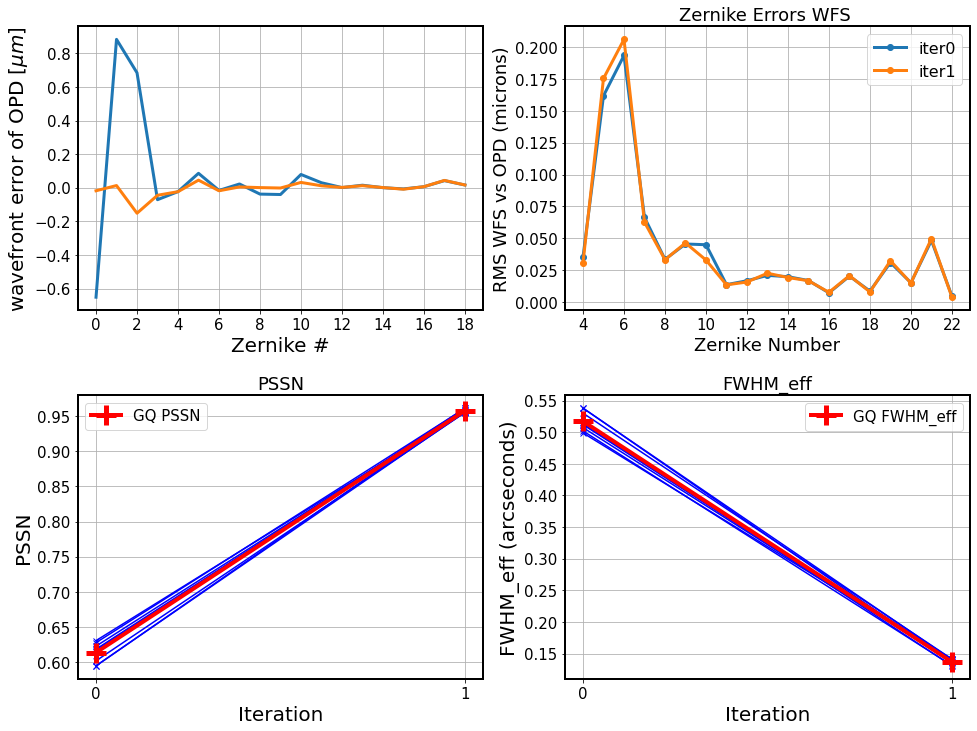

In [20]:
import sys
sys.path.append('/project/gmegias/aos/lsst_stack')
import analysis as at
import astropy.io.fits as fits
import imp
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams 

rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18 

sys.path.append('/project/gmegias/aos/lsst_stack')
data_dir = '/project/gmegias/aos/lsst_stack/perturbations/test/'

at.plotIterationSummary(data_dir, iterNum=2,)